# $\textbf{PROGRAMMING ASSIGNMENT - Lecture 6}$

1. Perform EDA
2. Training-Testing Split
3. Model Pipelining
4. Model Performance Evaluation

---

Data: [Occupancy Detection](https://archive.ics.uci.edu/dataset/357/occupancy+detection)

In [1]:
%matplotlib inline
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [2]:
occupancy_detection = fetch_ucirepo(id=357)
occupancy_detection.variables

,name,role,type,demographic,description,units,missing_values
0,id,ID,Integer,None,None,None,no
1,date,Feature,Date,None,None,None,no
2,Temperature,Feature,Integer,None,None,C,no
3,Humidity,Feature,Continuous,None,None,%,no
4,Light,Feature,Integer,None,None,Lux,no
5,CO2,Feature,Continuous,None,None,ppm,no
6,HumidityRatio,Feature,Continuous,None,None,kgwater-vapor/kg-air,no
7,Occupancy,Target,Binary,None,"0 for not occupied, 1 for occupied status",None,no


In [3]:
occupancy_detection.data.features.head()

,date,Temperature,Humidity,Light,CO2,HumidityRatio
0,2015-02-04 17:51:00,23.18,27.272,426,721.25,0.00479298817650529
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714,0.00478344094931065
2,2015-02-04 17:53:00,23.15,27.245,426,713.5,0.00477946352442199
3,2015-02-04 17:54:00,23.15,27.2,426,708.25,0.00477150882608175
4,2015-02-04 17:55:00,23.1,27.2,426,704.5,0.00475699293331518


In [4]:
occupancy_detection.data.targets.head()

,Occupancy
0,1.0
1,1.0
2,1.0
3,1.0
4,1.0


In [5]:
df = pd.merge(occupancy_detection.data.features.drop(columns=["date"]), occupancy_detection.data.targets, left_index=True, right_index=True)
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.272,426,721.25,0.00479298817650529,1.0
1,23.15,27.2675,429.5,714,0.00478344094931065,1.0
2,23.15,27.245,426,713.5,0.00477946352442199,1.0
3,23.15,27.2,426,708.25,0.00477150882608175,1.0
4,23.1,27.2,426,704.5,0.00475699293331518,1.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20562 entries, 0 to 20561
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    20562 non-null  object 
 1   Humidity       20562 non-null  object 
 2   Light          20562 non-null  object 
 3   CO2            20562 non-null  object 
 4   HumidityRatio  20562 non-null  object 
 5   Occupancy      20560 non-null  float64
dtypes: float64(1), object(5)
memory usage: 964.0+ KB


In [7]:
df = df.apply(lambda col : pd.to_numeric(col, errors='coerce'))
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20562 entries, 0 to 20561
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Temperature    20560 non-null  float64
 1   Humidity       20560 non-null  float64
 2   Light          20560 non-null  float64
 3   CO2            20560 non-null  float64
 4   HumidityRatio  20560 non-null  float64
 5   Occupancy      20560 non-null  float64
dtypes: float64(6)
memory usage: 964.0 KB


In [8]:
df.isna().sum()

Temperature      2
Humidity         2
Light            2
CO2              2
HumidityRatio    2
Occupancy        2
dtype: int64

In [9]:
df.dropna(inplace=True)
df.isna().sum()

Temperature      0
Humidity         0
Light            0
CO2              0
HumidityRatio    0
Occupancy        0
dtype: int64

In [10]:
df.head()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.18,27.2720,426.0,721.25,0.004793,1.0
1,23.15,27.2675,429.5,714.00,0.004783,1.0
2,23.15,27.2450,426.0,713.50,0.004779,1.0
3,23.15,27.2000,426.0,708.25,0.004772,1.0
4,23.10,27.2000,426.0,704.50,0.004757,1.0


In [11]:
df["Occupancy"] = df["Occupancy"].astype(int)
df.describe()

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
count,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000,20560.000000
mean,20.906212,27.655925,130.756622,690.553276,0.004228,0.231031
std,1.055315,4.982154,210.430875,311.201281,0.000768,0.421503
min,19.000000,16.745000,0.000000,412.750000,0.002674,0.000000
25%,20.200000,24.500000,0.000000,460.000000,0.003719,0.000000
50%,20.700000,27.290000,0.000000,565.416667,0.004292,0.000000
75%,21.525000,31.290000,301.000000,804.666667,0.004832,0.000000
max,24.408333,39.500000,1697.250000,2076.500000,0.006476,1.000000


### $\textbf{Data Exploration}$

**TASK: Create a correlation heatmap.**

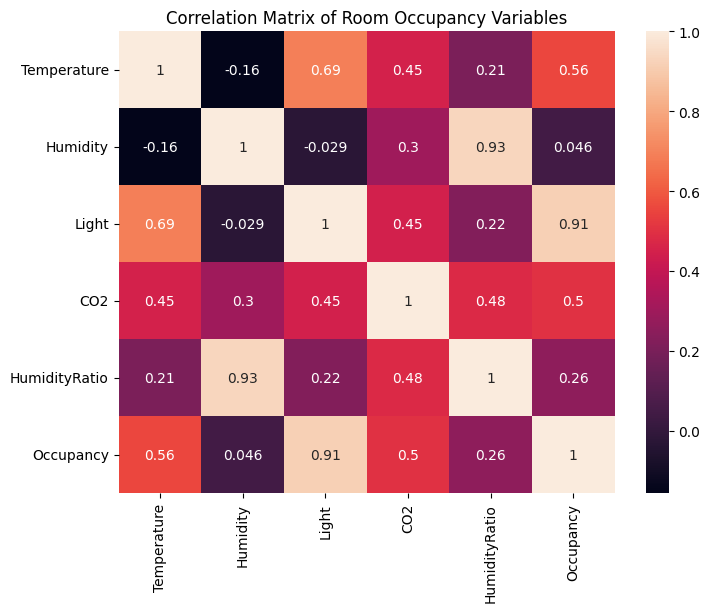

In [12]:
plt.figure(figsize=(8, 6))
plt.title("Correlation Matrix of Room Occupancy Variables")
sns.heatmap(df.corr(), annot=True)
plt.show()

**TASK: What are the top 5 correlated frequencies with the target\label?**

*Note: You many need to map the label to 0s and 1s.*

*Additional Note: We're looking for **absolute** correlation values.*

In [13]:
absolute_correlation_with_target = df.drop(columns=["Occupancy"]).corrwith(df["Occupancy"]).abs()
sorted_correlation = absolute_correlation_with_target.sort_values(ascending=False)

sorted_correlation[:5]

Light            0.914850
Temperature      0.555610
CO2              0.501582
HumidityRatio    0.257324
Humidity         0.046240
dtype: float64

### $\textbf{Training-Testing Split}$

**TASK: Split the data into features and labels, and then split into a training set and test set, with 90% for Cross-Validation training, and 10% for a final test set.**

*Note: Do not forget to put a random_state for reproducibility.*

In [14]:
X = df.drop(columns=["Occupancy"])
y = df["Occupancy"]

In [15]:
X.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
0,23.18,27.2720,426.0,721.25,0.004793
1,23.15,27.2675,429.5,714.00,0.004783
2,23.15,27.2450,426.0,713.50,0.004779
3,23.15,27.2000,426.0,708.25,0.004772
4,23.10,27.2000,426.0,704.50,0.004757


In [16]:
y.value_counts()

Occupancy
0    15810
1     4750
Name: count, dtype: int64

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42069)

In [18]:
X_train.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
18457,20.29,30.200,0.0,715.000000,0.004446
5208,19.20,31.100,6.0,431.333333,0.004278
9472,22.50,27.000,617.0,1040.000000,0.004552
11581,20.60,24.445,0.0,613.000000,0.003663
11276,20.50,27.995,0.0,486.500000,0.004173


In [19]:
X_test.head()

,Temperature,Humidity,Light,CO2,HumidityRatio
3863,21.356667,18.50,275.333333,457.333333,0.002901
17614,20.390000,24.29,0.000000,826.333333,0.003593
4162,21.890000,18.10,68.000000,446.000000,0.002933
7761,20.290000,32.90,0.000000,453.000000,0.004846
17441,20.426667,25.60,0.000000,796.000000,0.003797


In [20]:
y_train.value_counts()

Occupancy
0    14250
1     4254
Name: count, dtype: int64

In [21]:
y_test.value_counts()

Occupancy
0    1560
1     496
Name: count, dtype: int64

### $\textbf{Model Pipelining}$

**TASK: Create a PipeLine that contains both a StandardScaler and a KNN model**

In [22]:
scaler = StandardScaler()
knn = KNeighborsClassifier()

operations = [("scaler", scaler), ("knn", knn)]
pipe = Pipeline(operations)
pipe.named_steps

{'scaler': StandardScaler(), 'knn': KNeighborsClassifier()}

**TASK: Perform a grid-search with the pipeline to test various values of k and report back the best performing parameters.**

In [23]:
param_grid = { "knn__n_neighbors": list(range(1, 20)) }
grid_classifier = GridSearchCV(pipe, param_grid, cv=5, scoring="neg_mean_squared_error")
grid_classifier.fit(X_train, y_train)

grid_classifier.best_params_

{'knn__n_neighbors': 1}

In [24]:
grid_classifier.best_estimator_.get_params()

{'memory': None,
 'steps': [('scaler', StandardScaler()),
  ('knn', KNeighborsClassifier(n_neighbors=1))],
 'verbose': False,
 'scaler': StandardScaler(),
 'knn': KNeighborsClassifier(n_neighbors=1),
 'scaler__copy': True,
 'scaler__with_mean': True,
 'scaler__with_std': True,
 'knn__algorithm': 'auto',
 'knn__leaf_size': 30,
 'knn__metric': 'minkowski',
 'knn__metric_params': None,
 'knn__n_jobs': None,
 'knn__n_neighbors': 1,
 'knn__p': 2,
 'knn__weights': 'uniform'}

**(HARD) TASK: Using the .cv_results_ dictionary, see if you can create a plot of the mean test scores per K value.**

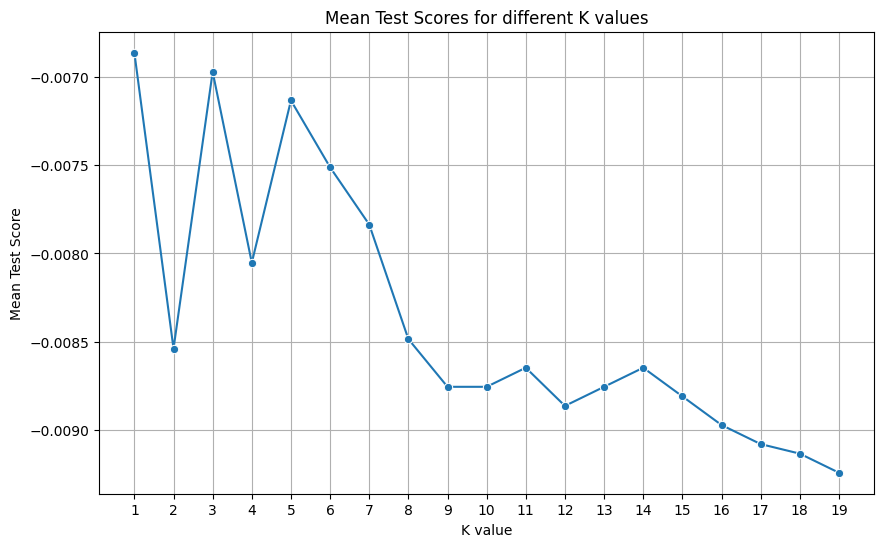

In [25]:
data = pd.DataFrame({
    'K value': param_grid['knn__n_neighbors'],
    'Mean Test Score': grid_classifier.cv_results_['mean_test_score']
})

plt.figure(figsize=(10, 6))
sns.lineplot(data=data, x='K value', y='Mean Test Score', marker='o')
plt.xticks(param_grid['knn__n_neighbors'])
plt.xlabel('K value')
plt.ylabel('Mean Test Score')
plt.title('Mean Test Scores for different K values')
plt.grid(True)
plt.show()

### $\textbf{Model Performance Evaluation}$

**TASK: Using the grid classifier object from the previous step, get a final performance classification report and confusion matrix.**

In [26]:
y_pred = grid_classifier.best_estimator_.predict(X_test)

In [27]:
accuracy_score(y_test, y_pred)

0.9946498054474708

In [28]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1560
           1       0.98      1.00      0.99       496

    accuracy                           0.99      2056
   macro avg       0.99      1.00      0.99      2056
weighted avg       0.99      0.99      0.99      2056



In [29]:
confusion_matrix(y_test, y_pred)

array([[1551,    9],
       [   2,  494]], dtype=int64)

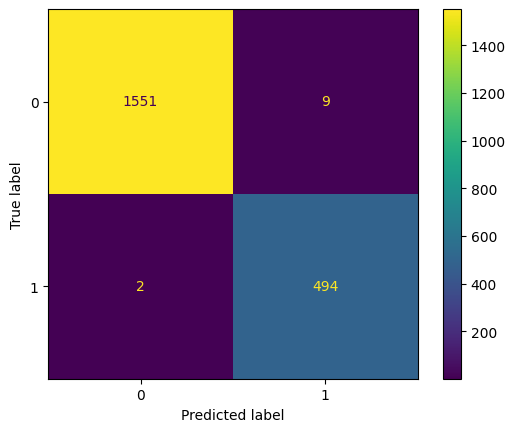

In [30]:
ConfusionMatrixDisplay.from_estimator(grid_classifier, X_test, y_test)

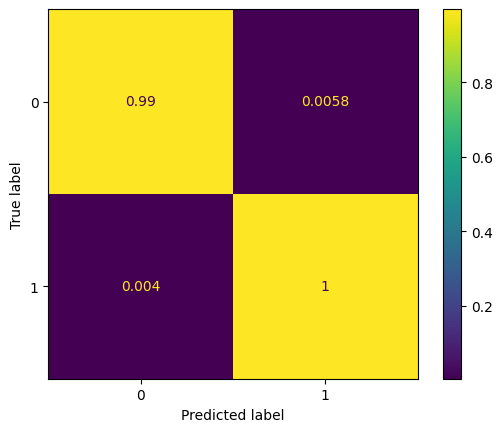

In [31]:
ConfusionMatrixDisplay.from_estimator(grid_classifier, X_test, y_test, normalize='true')